In [ ]:
!pip install HyperOpt==0.2.5
!pip install shap==0.39

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import datetime

import xgboost

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,accuracy_score, roc_auc_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV

from hyperopt import hp, STATUS_OK, fmin, tpe, Trials
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll.base import scope

import shap

import joblib

import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)


import seaborn as sns

sns.set_style('whitegrid')

In [5]:
caso = '0.01'

base = pd.read_excel('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/Base_join_buffer_{}.xlsx'.format(caso))
base['latlon'] = base.lat * base.lon

base['valor_log']  = np.log(base.valor)
# base

In [78]:
np.exp(14)

1202604.2841647768

In [48]:
# vars_chave = ['valor','dorm','vagas','banheiro','area_tot','lat','lon',
#               'RURAL',	'URBANO',	'Domicilios',	'Residentes',	'Residentes_por_domicilio',	'Rendimento_per_capita',	'densidade_hab_km2',
#               'mean','max','dist',
#               'restaurant','bar','store','supermarket','grocery_or_supermarket','police','school','convenience_store','bakery','atm','gas_station','gym','cafe','beauty_salon']

# MAPE 1 = 35
# MAPE 2 = 35

vars_chave = ['valor_log','dorm','banheiro','vagas','area_tot',
              'Domicilios',	'Residentes','Rendimento_per_capita',	'densidade_hab_km2',
              'mean','max','dist',
              'restaurant','bar','store','supermarket','grocery_or_supermarket','police','school','bakery']

# MAPE 1 = 35
# MAPE 2 = 29

base_mod = base.dropna()

base_mod = base[vars_chave]
# base = base[base.valor<3500000]

base_mod.columns = ['Valor Casa Log','Dormitorios','Banheiro','Vagas','Area Total',
                      'Domicilios',	'Residentes','Rendimento per Capita',	'Densidade hab km2',
                      'Média Enterococcus','Máximo Enterococcus','Distância da Bandeira',
                      'Restaurante','Bar','Lojas','Supermercado','Loja Conveniencia','Policia','Escola','Padaria']

vars_obj = 'Valor Casa Log'

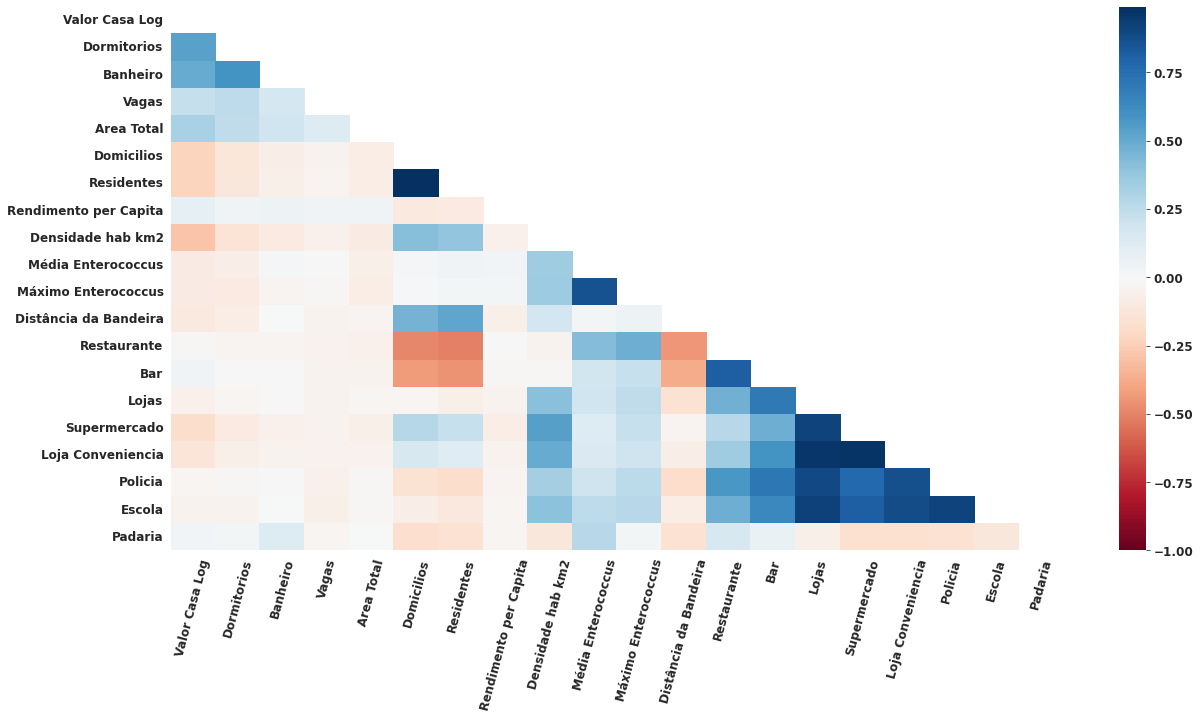

In [7]:
plt.figure(figsize=(20,10))

corr = base_mod.corr()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(corr,cmap='RdBu',vmin=-1,mask=matrix)

plt.xticks(rotation=75)

plt.savefig('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/Corr_plot.png',dpi=300,bbox='tight')

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


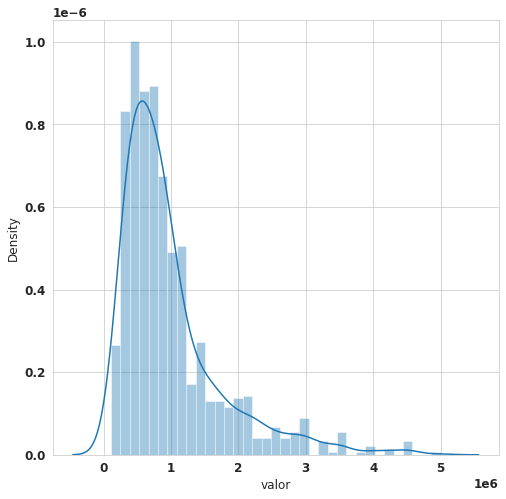

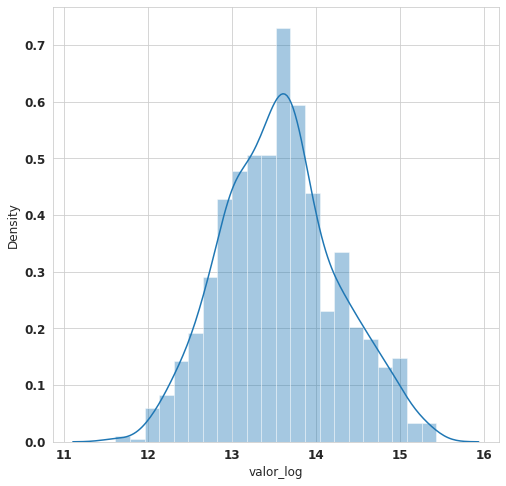

In [75]:
plt.figure(figsize=(8,8))
sns.distplot(base.valor)

plt.savefig('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/Distplot_valor_tot.png',dpi=300,bbox='tight')

plt.figure(figsize=(8,8))
sns.distplot(base.valor_log)

plt.savefig('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/Distplot_valor_log.png',dpi=300,bbox='tight')

#Tratamento Base

In [49]:
base_train, base_test = train_test_split(base_mod)

base_train_y = base_train[[vars_obj]]
base_test_y = base_test[[vars_obj]]

base_train_X = base_train.drop(vars_obj,axis=1)
base_test_X = base_test.drop(vars_obj,axis=1)

# Funções

In [50]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calcula a porcentagem do erro absoluto médio (MAPE).

    Args:
        y_true (pd.Series): Série com os valores reais.
        y_pred (pd.Series): Série com os valores estimados.

    Returns:
        float: Valor do MAPE calculado.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):
    """Calcula o erro absoluto médio (MAE).

    Args:
        y_true (pd.Series): Série com os valores reais.
        y_pred (pd.Series): Série com os valores estimados.

    Returns:
        float: Valor do MAE calculado.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def XGBoost_multivar_hyperopt_tuning(evaluation, space, num_eval):
    """Realiza o tunning de hiperparâmetros com hyperopt.

    Args:
        evaluation (list(tuples)): Uma list com as tuplas de datasets para serem utilizados.
        space (dict): Dicionário com os hiperparâmetros e seus valores a serem testados.
        num_eval (int): Número de testes realizados no processo.

    Returns:
        dict: Dicionário com os valores dos melhores hiperparâmetros encontrados.
    """

    def objective(space):

        clf = xgboost.XGBRegressor(**space, nthread=-1)

        clf.fit(
            evaluation[0][0],
            evaluation[0][1],
            eval_set=evaluation,
            eval_metric="rmse",
            verbose=False,
        )

        pred = clf.predict(evaluation[1][0])
        accuracy = mean_squared_error(evaluation[1][1], pred)

        return {"params": space, "loss": accuracy, "status": STATUS_OK}

    trials = Trials()

    best_hyperparams = fmin(
        fn=objective, space=space, algo=tpe.suggest, max_evals=num_eval, trials=trials
    )

    # deixando int
    best_hyperparams["max_depth"] = int(best_hyperparams["max_depth"])
    best_hyperparams["n_estimators"] = int(best_hyperparams["n_estimators"])
    best_hyperparams["scale_pos_weight"] = int(best_hyperparams["scale_pos_weight"])

    return best_hyperparams

def shap_Plots(X_output, model=None, tipo=None, name_const=None,path=''):
    """Retorna os plots com valores explicativos Shap para o conjunto total de treinamento, bem como para a ultima semana antes da previsão.
       

    Args:
        X_output (pd.dataframe): Conjunto de dados utilizados no treinamento do modelo utilizado.
        model (sklearn, XGBoost): Modelo treinando e utilizado nas previsões.
        tipo (str, optional): 
          tipo = tree : Faz a elaboração dos plots a partir do motor de árvore da biblioteca.
          tipo = XGBoost: chama função necessária para fazer a elaboração dos plots shap.
        name_const (str, optional): Nome utilizado para nomear os gráficos png resultantes.

    Returns:
        [dictionary]: Dicionário contendo os caminhos dos gráficos gerados no formato .png. Posteriormente as figuras são salvas no experimento como artefatos.
    """

    dic_shap = {}

    # Force Plot
    X_output = X_output.round(0)

    if tipo == "Tree":
        explainerModel = shap.TreeExplainer(model)
        shap_values_Model = explainerModel.shap_values(X_output)

        # salvando Shap Explainer e Values
        dic_shap["explainer"] = explainerModel
        dic_shap["shap_values"] = shap_values_Model

        # CASCATA ULTIMO TS
        plt.figure()
        p = shap.plots._waterfall.waterfall_legacy(
            explainerModel.expected_value[0],
            shap_values_Model[-1],
            feature_names=X_output.columns,
            show=False,
        )

        pathh = path + f"/Force_Cascata_{name_const}.png"
        plt.savefig(pathh, dpi=300, bbox_inches="tight")

        dic_shap["cascata"] = pathh
        #
        plt.close()

    elif tipo == "XGBoost":

        def xgb_predict(data_asarray):
            data_asframe = pd.DataFrame(data_asarray, columns=feature_names)
            return model.predict(data_asframe)

        feature_names = X_output.columns

        explainerModel = shap.KernelExplainer(xgb_predict, X_output)
        shap_values_Model = explainerModel.shap_values(X_output)

        # CASCATA ULTIMO TS
        plt.figure()
        p = shap.plots._waterfall.waterfall_legacy(
            explainerModel.expected_value,
            shap_values_Model[-1],
            feature_names=X_output.columns,
            show=False,
        )

        pathh = path + f"/Force_Cascata_{name_const}.png"
        plt.savefig(pathh, dpi=300, bbox_inches="tight")

        dic_shap["cascata"] = pathh
        plt.close()

    else:
        explainerModel = shap.KernelExplainer(model.predict, X_output)
        shap_values_Model = explainerModel.shap_values(X_output)

        # salvando Shap Explainer e Values
        dic_shap["explainer"] = explainerModel
        dic_shap["shap_values"] = shap_values_Model

        # CASCATA ULTIMO TS
        plt.figure()
        p = shap.plots._waterfall.waterfall_legacy(
            explainerModel.expected_value,
            shap_values_Model[-1],
            feature_names=X_output.columns,
            show=False,
        )

        pathh = path + f"/Force_Cascata_{name_const}.png"
        plt.savefig(pathh, dpi=300, bbox_inches="tight")

        dic_shap["cascata"] = pathh
        plt.close()

    # BEESWARM TOTAL
    plt.figure()
    shap.plots._beeswarm.summary_legacy(
        shap_values_Model, features=X_output, show=False
    )

    pathh = path + f"/Sumario_Pontos_{name_const}.png"
    plt.savefig(pathh, dpi=300, bbox_inches="tight")

    dic_shap["sumario_pontos"] = pathh

    plt.close()

    # PESO VARIÁVEIS
    plt.figure()
    shap.summary_plot(shap_values_Model, features=X_output, plot_type="bar", show=False)

    pathh = path + f"/Sumario_variaveis_{name_const}.png"
    plt.savefig(pathh, dpi=300, bbox_inches="tight")

    dic_shap["sumario_variaveis"] = pathh

    plt.close()

    # FORCE PLOT TOTAL
    a = shap.force_plot(
        explainerModel.expected_value,
        shap_values_Model,
        feature_names=X_output.columns,
        show=False,
    )

    pathh = path + f"/Force_Total_{name_const}.html"
    shap.save_html(pathh, a)

    dic_shap["force_total"] = pathh

    # FORCE PLOT ULTIMO TS
    p = shap.force_plot(
        explainerModel.expected_value,
        shap_values_Model[-1],
        X_output.iloc[[-1]],
        show=False,
    )

    pathh = path + f"/Force_Horizontal_{name_const}.html"
    shap.save_html(pathh, p)

    dic_shap["force_horizontal"] = pathh

    return dic_shap,explainerModel,shap_values_Model

# Hiperparametros

In [ ]:
# XGBoost grid params
space = {
    "max_depth": scope.int(hp.quniform("max_depth", 3, 100, 1)),
    "gamma": hp.uniform("gamma", 1, 15),
    "reg_alpha": hp.quniform("reg_alpha", 40, 2000, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 0, 20, 1),
    "n_estimators": scope.int(hp.quniform("n_estimators", 10, 1000, 5)),
    "scale_pos_weight": hp.quniform("scale_pos_weight", 1, 20, 1),
    "seed": 0,
    "objective": "reg:squarederror",
    "booster": "gblinear",
}

evaluation = [(base_train_X, base_train_y), (base_test_X, base_test_y)]

# get best hyperparams
best_hyperparams = XGBoost_multivar_hyperopt_tuning(evaluation, space, 100)

# set manually cause it doesn't come back from the grid
best_hyperparams["seed"] = 0
best_hyperparams["objective"] = "reg:squarederror"
best_hyperparams["booster"] = "gbtree"

100%|██████████| 100/100 [01:48<00:00,  1.08s/trial, best loss: 0.4761338802927148]


# Modelo Randomized

In [51]:
# model = xgboost.XGBRegressor(**best_hyperparams, nthread=-1)
model = xgboost.XGBRegressor( nthread=-1)

space = {'objective':['reg:squarederror'],
              'booster':['gbtree','gblinear'],
              'learning_rate': [0.1,0.3,0.5], 
              'max_depth': [5,7,10,15,20,30,50,100,500],
              'min_child_weight': [5,10,15,20,25,30,50,100],
              'colsample_bytree': [0.5,0.6,0.7,0.8, 0.9, 1],
              'n_estimators': [25,50,100,150,200,300,400,500,600,1000],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [1,2,3,5,10,15,20],
              "gamma"       : [1,2,3,4,5,10,15]
          }

xgb_cv = RandomizedSearchCV(model,space, cv=15,n_iter=50,scoring='neg_mean_absolute_error',verbose=5,n_jobs=12)

# train model with train dataset
train_model = xgb_cv.fit(base_train_X, base_train_y)

# predict on test dataset
fore_test = train_model.predict(base_test_X)
fore_test = pd.DataFrame(fore_test, columns=["yhat"])
fore_test.index = base_test_X.index

# calculate metrics
# dic_metricas = {
#     "MAE": mean_absolute_error(
#         base_test_y['valor'], fore_test["yhat"]
#     ),
#     "MAPE": mean_absolute_percentage_error(
#         base_test_y['valor'], fore_test["yhat"]
#     ),
#     "RMSE": mean_squared_error(
#         base_test_y['valor'], fore_test["yhat"], squared=False
#     )
# }

dic_metricas = {
    "MAE": mean_absolute_error(
        base_test_y['Valor Casa Log'], fore_test["yhat"]
    ),
    "MAPE": mean_absolute_percentage_error(
        base_test_y['Valor Casa Log'], fore_test["yhat"]
    ),
    "RMSE": mean_squared_error(
        base_test_y['Valor Casa Log'], fore_test["yhat"], squared=False
    )
}

dic_metricas

Fitting 15 folds for each of 50 candidates, totalling 750 fits


{'MAE': 0.3178032982217201,
 'MAPE': 2.3379938348479055,
 'RMSE': 0.4339918390198964}

In [68]:
xgb_cv.best_estimator_

XGBRegressor(colsample_bytree=0.8, gamma=1, learning_rate=0.5, max_depth=500,
             min_child_weight=25, n_estimators=400, nthread=-1,
             objective='reg:squarederror', reg_alpha=0.5, reg_lambda=3)

#Validação do Modelo


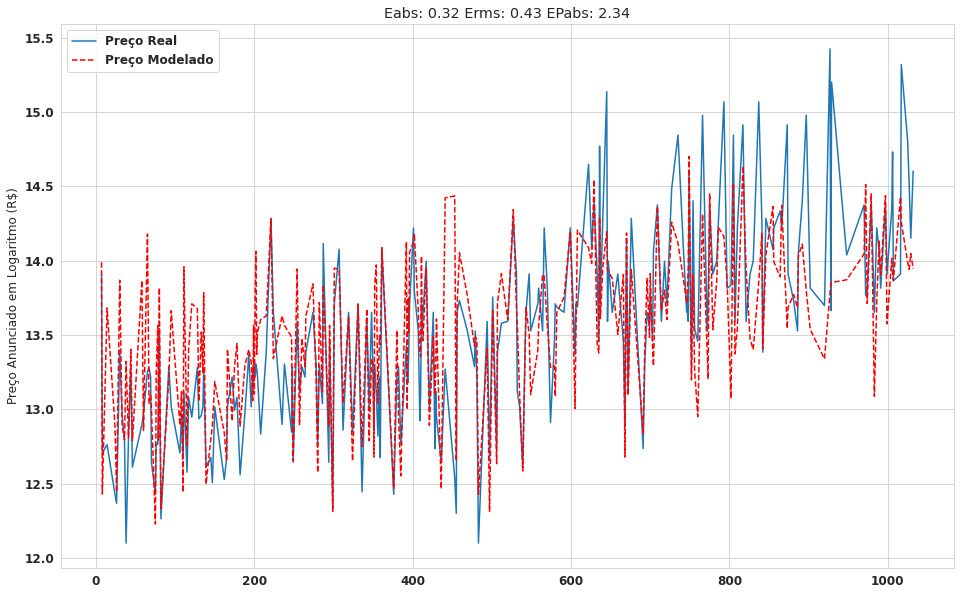

In [70]:
base_test_y = base_test_y.sort_index()
fore_test = fore_test.sort_index()

fig,ax = plt.subplots(figsize=(16,10))
ax = base_test_y.plot(ax=ax,legend=True)
fore_test.plot(ax=ax,color='r',linestyle='--',legend=True)

plt.ylabel('Preço Anunciado em Logaritmo (R$)')

plt.title('Eabs: {} Erms: {} EPabs: {}'.format(np.round(dic_metricas['MAE'],2),
                                          np.round(dic_metricas['RMSE'],2),
                                          np.round(dic_metricas['MAPE'],2)))

plt.legend(['Preço Real','Preço Modelado'])

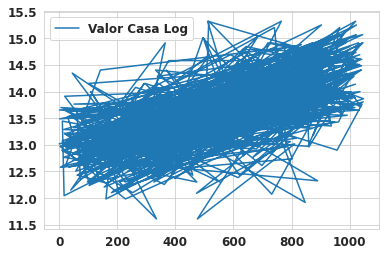

In [74]:
base_train_y.plot()

# Modelo Hyperopt

In [ ]:
# model = xgboost.XGBRegressor(**best_hyperparams, nthread=-1)

# # train model with train dataset
# train_model = model.fit(base_train_X, base_train_y)

# # predict on test dataset
# fore_test = train_model.predict(base_test_X)
# fore_test = pd.DataFrame(fore_test, columns=["yhat"])

# calculate metrics
# dic_metricas = {
#     "MAE": mean_absolute_error(
#         base_test_y['valor'], fore_test["yhat"]
#     ),
#     "MAPE": mean_absolute_percentage_error(
#         base_test_y['valor'], fore_test["yhat"]
#     ),
#     "RMSE": mean_squared_error(
#         base_test_y['valor'], fore_test["yhat"], squared=False
#     )
# }

# dic_metricas = {
#     "MAE": mean_absolute_error(
#         base_test_y['Valor Casa Log'], fore_test["yhat"]
#     ),
#     "MAPE": mean_absolute_percentage_error(
#         base_test_y['Valor Casa Log'], fore_test["yhat"]
#     ),
#     "RMSE": mean_squared_error(
#         base_test_y['Valor Casa Log'], fore_test["yhat"], squared=False
#     )
# }

# dic_metricas

{'MAE': 0.41602994984468655,
 'MAPE': 3.0213253981417267,
 'RMSE': 0.546208362209121}

In [ ]:
name_const = "multivar_XG_hedonic_pricing_Ubatuba_buff_{}".format(caso)
shapp,a,b = shap_Plots(base_train_X, model=train_model, tipo="XGBoost", name_const=name_const, path = '/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico')

Using 786 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/786 [00:00<?, ?it/s]

A saída de streaming foi truncada nas últimas 5000 linhas.
model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter al

In [ ]:
df_shap = pd.DataFrame(b)

df_shap.columns = base_train_X.columns

df_shap.to_excel('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/Modelo_Hedonico_XGBoost_shap_values.xlsx')

In [ ]:
shap.decision_plot(a.expected_value,b,features=base_train_X.columns)

plt.savefig('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/Decision_Plot.png',dpi=300,bbox='tight')

ValueError: ignored

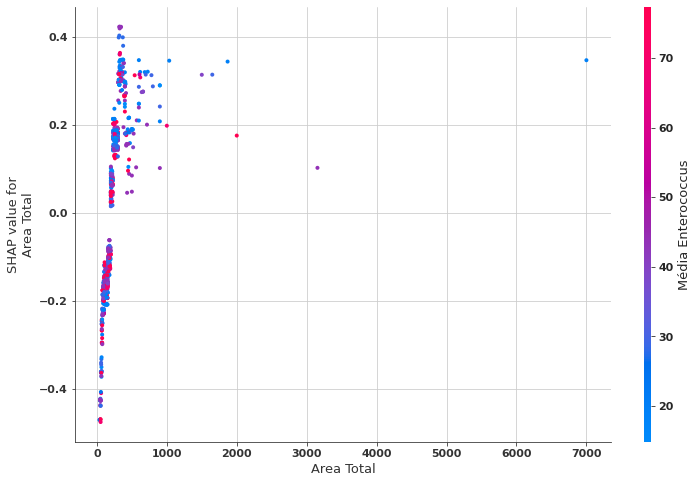

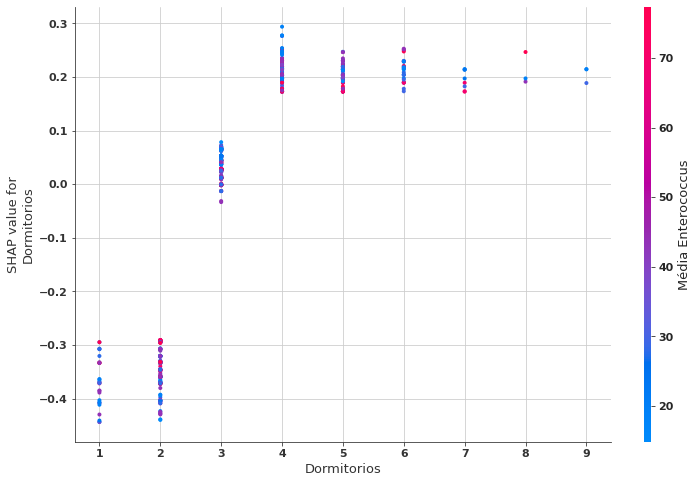

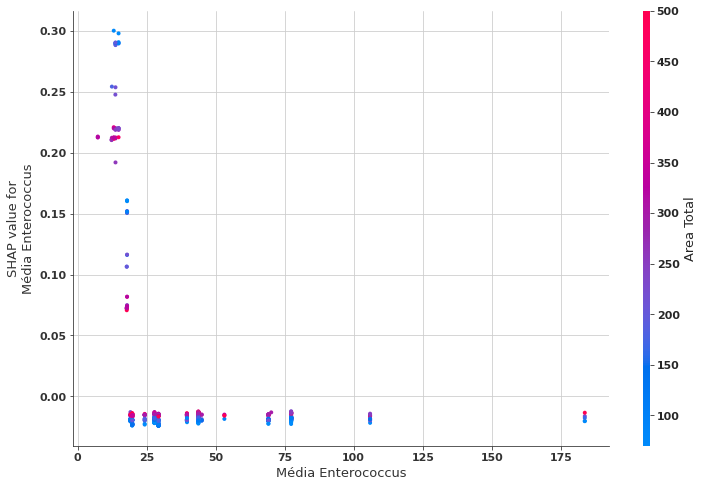

In [ ]:
shap.dependence_plot("Area Total", b, base_train_X,interaction_index='Média Enterococcus',show=False)

#parametros para deixar a figura maior
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(12)

plt.savefig('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/Area_TotalxMedia.png',dpi=300,bbox='tight')

shap.dependence_plot("Dormitorios", b, base_train_X,interaction_index='Média Enterococcus',show=False)

#parametros para deixar a figura maior
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(12)

plt.savefig('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/DormxMedia.png',dpi=300,bbox='tight')


shap.dependence_plot("Média Enterococcus", b, base_train_X, interaction_index='Area Total',show=False)

#parametros para deixar a figura maior
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(12)

plt.savefig('/content/drive/MyDrive/PROCAM/Dissertação/dados/Bases_Modelo_Hedonico/MediaxAreaTotal.png',dpi=300,bbox='tight')

shap.dependence_plot("Média Enterococcus", b, base_train_X, interaction_index='MediaxRendimento per Capita',show=False)

#parametros para deixar a figura maior
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(12)